# Estimating a One-factor (Short-Rate) Model
## Based on 2.4.1

The model is setup as follows:

<center>
<font size='4'>

$
r_t = c + \alpha r_{t-1} + \sigma_r e_t \\
Y_t = a_\tau + b_\tau r_t + \Sigma_y u_t    
$
    
</font>
</center>

Where the short-rate $ r_t $ is modelled as a AR(1), and the term-structure $ Y_t $ is modelled with the short rate as the single factor. Specifically, $ Y_t $ is a $ \tau \times 1 $ vector, where $ \tau $ denotes the number of tenors modelled. $ e_t $ and $ u_t $ are $ N(0,1) $, $ \sigma_r $ is the volatility of the short-rate and $ \Sigma_y $ is the covariance matrix of the term-structure.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

### Data

Note: below uses textbook data, but next step should be to understand how the yearly yearly curve is interpolated into monthly, and what sort of model/transformaion is applied to go from the daily zero rates to the monthly (transformed) rates

In [2]:
data = pd.read_excel("textbook_data.xlsx", header=3, index_col=0)
data = data.filter(regex="^US_Y[0-9].*") # monthly US zero-rates
data.columns = data.columns.str.replace('US_Y','y')
data.index = data.index.rename("Date")

In [3]:
data

,y3,y12,y24,y36,y48,y60,y72,y84,y96,y108,y120
Date,,,,,,,,,,,
1975-01-31,6.206589,6.238884,6.670026,6.910766,7.041402,7.120725,7.173689,7.211528,7.239907,7.261980,7.279638
1975-02-28,6.090830,5.916754,6.278823,6.594526,6.800582,6.934522,7.025900,7.091580,7.140920,7.179310,7.210025
1975-03-31,6.007056,6.241704,6.757098,7.029764,7.176597,7.265656,7.325112,7.367588,7.399445,7.424224,7.444046
1975-04-30,6.066437,6.791323,7.412003,7.642909,7.758730,7.828228,7.874560,7.907654,7.932475,7.951780,7.967224
1975-05-30,5.348095,6.106194,6.781078,7.132689,7.327140,7.446369,7.526196,7.583260,7.626064,7.659356,7.685990
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,2.102200,2.454839,2.619778,2.681681,2.716117,2.743053,2.767769,2.791431,2.814080,2.835515,2.855561
2018-09-28,2.191995,2.620719,2.801011,2.866557,2.903993,2.933405,2.959735,2.984103,3.006661,3.027382,3.046260
2018-10-31,2.275757,2.694127,2.860678,2.915822,2.950248,2.983280,3.017837,3.053180,3.088082,3.121574,3.153050


### Model Estimation


<font size='4'>

$$
r_t = c + \alpha r_{t-1} + \sigma_r e_t \\
Y_t = a_\tau + b_\tau r_t + \Sigma_y u_t    
$$
    
</font>


In state-space notation:

<font size='4'>
    The state equation:
$$
\begin{bmatrix} r_{t}\\ \iota\\ \end{bmatrix} = 
    \begin{bmatrix} \alpha & c\\ 0 & 1\\ \end{bmatrix} \begin{bmatrix} r_{t-1}\\ \iota\\ \end{bmatrix}  + \sigma_r e_t
$$
    
    The observation equation:
    
$$
\begin{bmatrix} y_t\\ r_t \\ \iota \\ \end{bmatrix} = 
    \begin{bmatrix} b_\tau & a_\tau\\ 1 & 0\\ 0 & 1 \end{bmatrix} \begin{bmatrix} r_t\\ \iota\\ \end{bmatrix} + 
    \Sigma_y u_t    
$$
<font>

Below setups up the estimation in a simultaneous OLS framework.

****need to first estimate the state equation, obatin the estimates, and then stack those onto the observation equation(s), and then estimate it****

The state equation is stacked onto the observation equations (which themselves are stacked by tenor), and a vector of coefficients are estimated.

In [4]:
# Data prep
y = data.iloc[1:]

r_t1 = data['y3'].shift(1)
r_t1 = sm.add_constant(r_t1).iloc[1:]

r_t = data['y3']
r_t = sm.add_constant(r_t).iloc[1:]

In [5]:
# 1st Step
model1 = sm.OLS(r_t, r_t1)
results1 = model1.fit()
r_t_hat = model1.predict(results1.params, exog=r_t1)[:,1]

In [6]:
r_t_hat = pd.DataFrame(r_t_hat, columns=['y3_hat'], index=r_t.index)
r_t_hat = sm.add_constant(r_t_hat)

X = pd.merge(r_t1, pd.concat([r_t_hat]*(11), axis=1, ignore_index=True), on=['Date']) 

In [7]:
const_names = [(i,"const_"+str(i)) for i in X.iloc[:,2::2].columns.values]
y3_names = [(i,"y3_hat"+str(i)) for i in X.iloc[:,3::2].columns.values]
X.rename(columns = dict(const_names), inplace=True)
X.rename(columns = dict(y3_names), inplace=True)

In [8]:
model = sm.OLS(y,X)
results = model.fit()

In [9]:
prediction = model.predict(results.params, exog=X)

In [10]:
prediction = pd.DataFrame(data = prediction, index=y.index, columns=y.columns)

#### 10-year prediction

In [11]:
y120 = y['y120']
y120_hat = prediction['y120']

plot = pd.merge(y120, y120_hat, on=["Date"])

<AxesSubplot:xlabel='Date'>

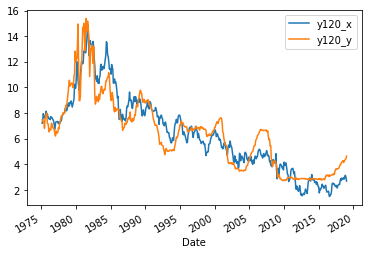

In [12]:
plot.plot()

#### 2-year prediction

<AxesSubplot:xlabel='Date'>

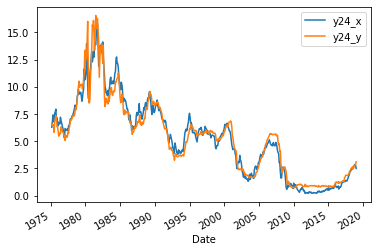

In [13]:
y24 = y['y24']
y24_hat = prediction['y24']

plot2 = pd.merge(y24, y24_hat, on=["Date"])

plot2.plot()

#### Yield Curve

<AxesSubplot:>

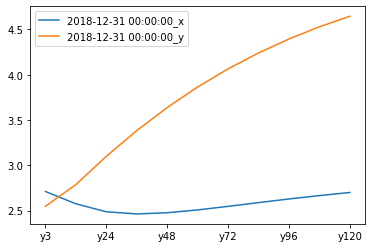

In [14]:
yc_pred = prediction.iloc[-1]
yc = y.iloc[-1]

plot3 = pd.merge(yc, yc_pred, left_index=True, right_index=True)

plot3.plot()

In [16]:
yc_pred

y3      2.546635
y12     2.786718
y24     3.098295
y36     3.382494
y48     3.637378
y60     3.864013
y72     4.064278
y84     4.240353
y96     4.394492
y108    4.528902
y120    4.645679
Name: 2018-12-31 00:00:00, dtype: float64

#### Term Structure of Yields

In [237]:
y

,y3,y12,y24,y36,y48,y60,y72,y84,y96,y108,y120
Date,,,,,,,,,,,
1975-02-28,6.090830,5.916754,6.278823,6.594526,6.800582,6.934522,7.025900,7.091580,7.140920,7.179310,7.210025
1975-03-31,6.007056,6.241704,6.757098,7.029764,7.176597,7.265656,7.325112,7.367588,7.399445,7.424224,7.444046
1975-04-30,6.066437,6.791323,7.412003,7.642909,7.758730,7.828228,7.874560,7.907654,7.932475,7.951780,7.967224
1975-05-30,5.348095,6.106194,6.781078,7.132689,7.327140,7.446369,7.526196,7.583260,7.626064,7.659356,7.685990
1975-06-30,6.298449,6.760839,7.134859,7.345354,7.464416,7.532246,7.571287,7.594085,7.607667,7.615981,7.621250
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,2.102200,2.454839,2.619778,2.681681,2.716117,2.743053,2.767769,2.791431,2.814080,2.835515,2.855561
2018-09-28,2.191995,2.620719,2.801011,2.866557,2.903993,2.933405,2.959735,2.984103,3.006661,3.027382,3.046260
2018-10-31,2.275757,2.694127,2.860678,2.915822,2.950248,2.983280,3.017837,3.053180,3.088082,3.121574,3.153050


In [252]:
def plottable_3d_info(df: pd.DataFrame):
    """
    Transform Pandas data into a format that's compatible with
    Matplotlib's surface and wireframe plotting.
    """
    index = df.index
    columns = df.columns

    x, y = np.meshgrid(np.arange(len(columns)), np.arange(len(index)))
    z = np.array([[df[c][i] for c in columns] for i in index])
    
    xticks = dict(ticks=np.arange(len(columns)), labels=columns)
    yticks = dict(ticks=np.arange(len(index)), labels=index)
    
    return x, y, z, xticks, yticks

In [253]:
### Transform to Matplotlib friendly format.
x, y, z, xticks, yticks = plottable_3d_info(y)

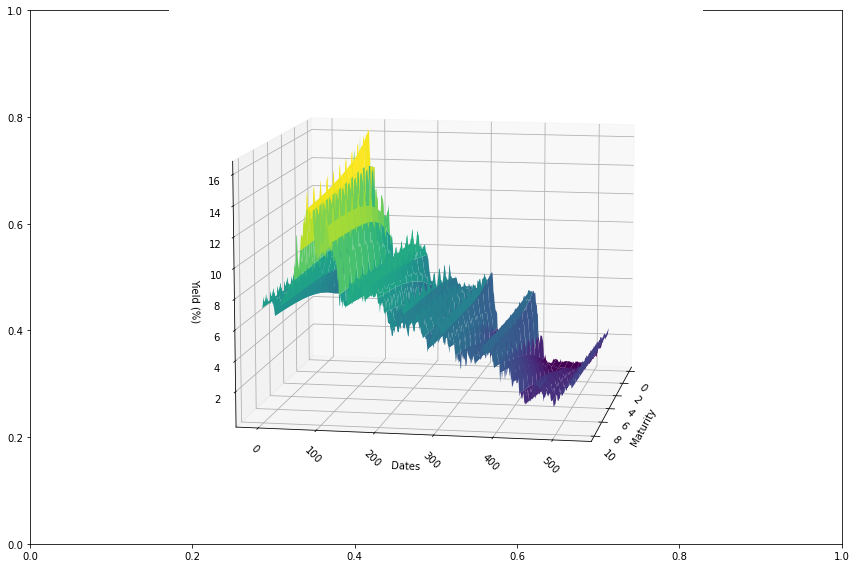

In [326]:
### Set up axes and put data on the surface.
fig, axs = plt.subplots(figsize=(12, 8))


ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# ax.yaxis_date()

ax.set_xlabel('Maturity')
ax.set_ylabel('Dates')
ax.set_zlabel('Yield (%)')

ax.view_init(elev=10, azim=10, vertical_axis='z')
plt.xticks(rotation=-45)
plt.yticks(rotation=-45)
plt.tight_layout()

plt.show()

In [10]:
# Organize Data
short_rate = data[["y3"]].copy()
date = pd.date_range(start = short_rate.index[0], end = short_rate.index[-1], freq="M")
short_rate.index = date

y_curve = data.iloc[:,1:].copy()

# short_rate, y_curve

In [5]:
# Setup the custom state-space model
starting_values = {
    'sigma_r': 0.01,
    'Sigma_y': np.repeat(0.01,y_curve.shape[1]),
    'alpha' : 1,
    'c' : 0,
    'b' : 1,
    'a' : 1,
}

class OneFactorModel(sm.tsa.statespace.MLEmodel):
    def __init__(self, Y_t: np.array, r_t: np.array, one_t: np.array):
        
        super(OneFactorModel), self.__init__(
            endog = np.c_[Y_t, r_t, one_t], k_states = 1, initialization = "diffuse"
        )
        
        # Creates Matrices
        self.ssm['design'] = np.array([b, a], [1, 0], [0, 1])
        self.ssm['transition'] = np.array([alpha, c], [0, 1])
        self.ssm["selection"] = np.eye(self.k_states)
        
        self.position_dict = OrderedDict(
            sigma_r=1, Sigma_y=2, alpha=3, c=4, b=5, a=6 
        )
        self.initial_values = starting_values
        self.positive_parameters = slice(0,4)
        
        
    @property
    def param_names(self):
        return list(self.position_dict.keys())

    @property
    def start_params(self):
        params = np.r_[
            self.initial_values['alpha'],
            self.initial_values['c'], 
            self.initial_values['b'],
            self.initial_values['a'],
        ]
        return params


    def update(self, params, **kwargs):
        params = super(OneFactorModel, self).update(params, **kwargs)

        self['design', 0, 0] = params[2]
        self['design', 0, 0] = params[3]

        self['transition', 0, 0] = params[0]
        self['transition', 0, 1] = params[1]

NameError: name 'y_curve' is not defined

In [20]:
# Chat GPT given above system:
class StateSpaceModel(sm.tsa.statespace.MLEModel):
    def __init__(self, data, c, alpha, sigma_r, a_tau, b_tau, sigma_y):
        # Define the state space matrices
        self.c = c
        self.alpha = alpha
        self.sigma_r = sigma_r
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.sigma_y = sigma_y

        self.transition = np.array([[alpha]])
        self.state_intercept = np.array([c])
        self.selection = np.array([[b_tau]])
        self.state_cov = np.array([[sigma_r**2]])
        self.obs_intercept = np.array([a_tau])
        self.obs_cov = np.array([[sigma_y**2]])

        super(StateSpaceModel, self).__init__(data,
                                              self.transition, self.state_intercept, 
                                              self.selection, self.state_cov, self.obs_intercept, self.obs_cov)

    def update(self, params, **kwargs):
        self.c = params[0]
        self.alpha = params[1]
        self.sigma_r = params[2]
        self.a_tau = params[3]
        self.b_tau = params[4]
        self.sigma_y = params[5]
        self.transition = np.array([[self.alpha]])
        self.state_intercept = np.array([self.c])
        self.selection = np.array([[self.b_tau]])
        self.state_cov = np.array([[self.sigma_r**2]])
        self.obs_intercept = np.array([self.a_tau])
        self.obs_cov = np.array([[self.sigma_y**2]])

    def loglike(self, params):
        self.update(params)
        return super(StateSpaceModel, self).loglike()

In [43]:
# Example of using the StateSpaceModel
data = np.c_[sm.add_constant(y_curve.iloc[:,0:2]), sm.add_constant(short_rate)]

mod = StateSpaceModel(data, 
                      c=0.1, alpha=0.05, sigma_r=0.01, a_tau=2, b_tau=0.5, sigma_y=0.02)
res = mod.fit()
print(res.summary())

TypeError: __init__() takes from 3 to 6 positional arguments but 8 were given

### Results